In [1]:
import pandas as pd
import torch
from transformers import pipeline
import matplotlib.pyplot as plt

c:\Users\User\miniconda3\envs\eda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def preprocess(df):
    df = df[['place', 'text']].copy()
    df['text'] = df['text'].astype(str).str.replace(',', '', regex=False)
    return df

def get_sentiment_scores(df, classifier, model_type, positive_label=None):
    reviews = df['text'].tolist()
    all_scores = classifier(reviews, batch_size=32)
    cont_scores = []

    if model_type == "nlptown":
        # label에서 별점만 추출해 0~1로 변환
        for score_list in all_scores:
            label = score_list[0]['label'] # '5 stars' 등
            star = int(label[0])
            score = (star - 1) / 4
            cont_scores.append(score)
    else:
        for score_list in all_scores:
            if positive_label is not None:
                score = next(s['score'] for s in score_list if s['label'] == positive_label)
            else:
                # label 자동 추출 (positive/negative 등)
                score = score_list[0]['score']  # 가장 높은 softmax
            cont_scores.append(score)
    df = df.copy()
    df['sentiment_cont'] = cont_scores
    return df

def analyze_sentiment_distribution(top_file, bottom_file, model_name, save_prefix, model_type, positive_label=None):
    print(f"\n[실험 모델] {model_name}")
    print("CUDA available:", torch.cuda.is_available())
    top_df = pd.read_csv(top_file, encoding='utf-8')
    bottom_df = pd.read_csv(bottom_file, encoding='utf-8')
    top_df = preprocess(top_df)
    bottom_df = preprocess(bottom_df)
    
    classifier = pipeline(
        "sentiment-analysis",
        model=model_name,
        top_k=None,
        batch_size=32,
        truncation=True,
        max_length=512
    )
    # positive_label 자동 감지 (필요시)
    if model_type not in ["nlptown"]:
        if positive_label is None:
            test_out = classifier(["좋아요!"], batch_size=1)[0]
            if any(s['label'] == 'positive' for s in test_out):
                positive_label = 'positive'
            elif any(s['label'] == 'LABEL_1' for s in test_out):
                positive_label = 'LABEL_1'
            else:
                print("Warning: positive_label 자동 감지 실패. 직접 지정 필요.")
                positive_label = test_out[0]['label']
    
    top_df = get_sentiment_scores(top_df, classifier, model_type, positive_label)
    bottom_df = get_sentiment_scores(bottom_df, classifier, model_type, positive_label)
    
    # 저장
    top_path = f'{save_prefix}_top100_with_sentiment.csv'
    bottom_path = f'{save_prefix}_bottom100_with_sentiment.csv'
    top_df.to_csv(top_path, index=False, encoding='utf-8')
    bottom_df.to_csv(bottom_path, index=False, encoding='utf-8')
    print(f"저장 완료: {top_path}, {bottom_path}")

    # 통계 출력
    print("상위 100 관광지 리뷰 감성분석 연속분포")
    print(top_df['sentiment_cont'].describe())
    print()
    print("하위 100 관광지 리뷰 감성분석 연속분포")
    print(bottom_df['sentiment_cont'].describe())

    # 시각화
    plt.figure(figsize=(8,4))
    plt.hist(top_df['sentiment_cont'], bins=30, alpha=0.7, label='Top 100')
    plt.hist(bottom_df['sentiment_cont'], bins=30, alpha=0.7, label='Bottom 100')
    plt.xlabel('Sentiment Score (Positive Probability)')
    plt.ylabel('Review Count')
    plt.title(f'Sentiment Distribution ({model_name}): Top 100 vs Bottom 100')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [17]:
model_info = [
    {
        "model_name": "WhitePeak/bert-base-cased-Korean-sentiment",
        "save_prefix": "WhitePeak_bert_base",
        "model_type": "whitepeak",
        "positive_label": "LABEL_1",
        "desc": "감성분석 파인튜닝, 3-class"
    },
    {
        "model_name": "distilbert-base-uncased-finetuned-sst-2-english",
        "save_prefix": "distilbert_sst2",
        "model_type": "sst2",
        "positive_label": "POSITIVE"
    },
    {
        "model_name": "cardiffnlp/twitter-roberta-base-sentiment-latest",
        "save_prefix": "cardiffnlp_roberta",
        "model_type": "cardiff",
        "positive_label": "positive"
    },
    {
        "model_name": "nlptown/bert-base-multilingual-uncased-sentiment",
        "save_prefix": "nlptown_bert",
        "model_type": "nlptown",
        "positive_label": None   # label에서 직접 변환
    },
]


[실험 모델] WhitePeak/bert-base-cased-Korean-sentiment
CUDA available: True


Device set to use cuda:0


저장 완료: WhitePeak_bert_base_top100_with_sentiment.csv, WhitePeak_bert_base_bottom100_with_sentiment.csv
상위 100 관광지 리뷰 감성분석 연속분포
count    8419.000000
mean        0.769544
std         0.353076
min         0.002682
25%         0.520653
50%         0.979879
75%         0.991699
max         0.992471
Name: sentiment_cont, dtype: float64

하위 100 관광지 리뷰 감성분석 연속분포
count    5209.000000
mean        0.803550
std         0.330263
min         0.002668
25%         0.830266
50%         0.988562
75%         0.992113
max         0.992490
Name: sentiment_cont, dtype: float64


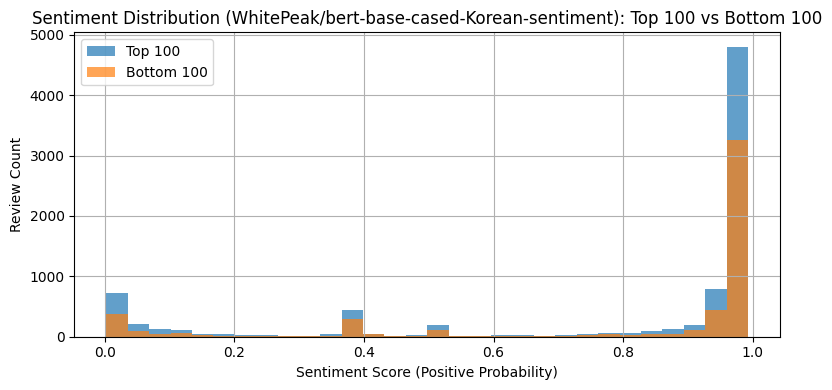


[실험 모델] distilbert-base-uncased-finetuned-sst-2-english
CUDA available: True


Device set to use cuda:0


저장 완료: distilbert_sst2_top100_with_sentiment.csv, distilbert_sst2_bottom100_with_sentiment.csv
상위 100 관광지 리뷰 감성분석 연속분포
count    8419.000000
mean        0.665696
std         0.207531
min         0.031410
25%         0.561540
50%         0.714009
75%         0.814636
max         0.999885
Name: sentiment_cont, dtype: float64

하위 100 관광지 리뷰 감성분석 연속분포
count    5209.000000
mean        0.671197
std         0.208706
min         0.056532
25%         0.566926
50%         0.718504
75%         0.822024
max         0.999880
Name: sentiment_cont, dtype: float64


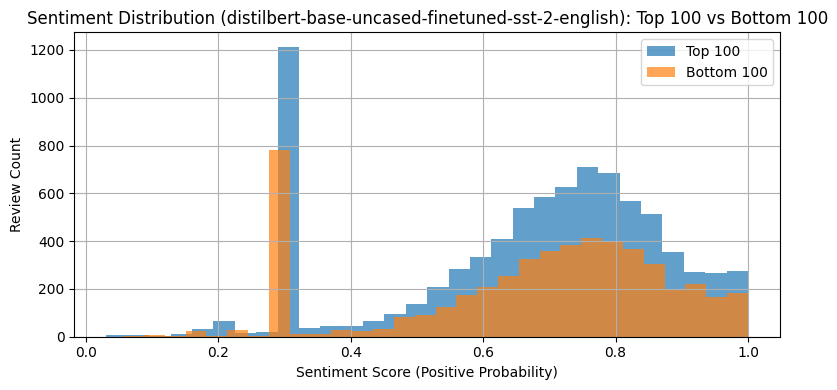


[실험 모델] cardiffnlp/twitter-roberta-base-sentiment-latest
CUDA available: True


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


저장 완료: cardiffnlp_roberta_top100_with_sentiment.csv, cardiffnlp_roberta_bottom100_with_sentiment.csv
상위 100 관광지 리뷰 감성분석 연속분포
count    8419.000000
mean        0.172005
std         0.126715
min         0.034877
25%         0.114327
50%         0.132207
75%         0.163689
max         0.989170
Name: sentiment_cont, dtype: float64

하위 100 관광지 리뷰 감성분석 연속분포
count    5209.000000
mean        0.174281
std         0.119261
min         0.054031
25%         0.115270
50%         0.135666
75%         0.169810
max         0.986098
Name: sentiment_cont, dtype: float64


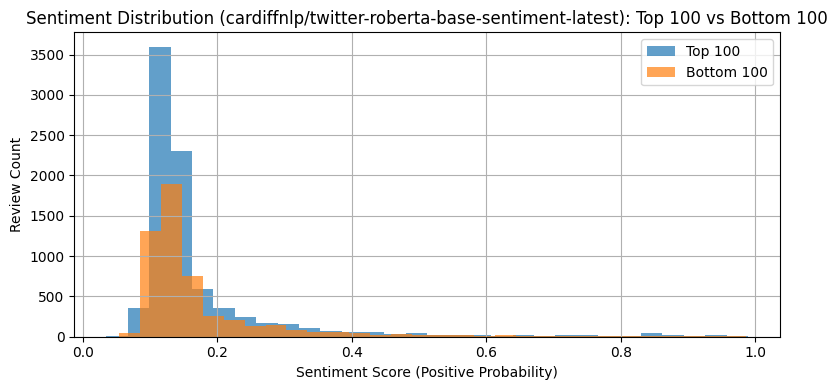


[실험 모델] nlptown/bert-base-multilingual-uncased-sentiment
CUDA available: True


Device set to use cuda:0


저장 완료: nlptown_bert_top100_with_sentiment.csv, nlptown_bert_bottom100_with_sentiment.csv
상위 100 관광지 리뷰 감성분석 연속분포
count    8419.000000
mean        0.615542
std         0.347011
min         0.000000
25%         0.250000
50%         0.500000
75%         1.000000
max         1.000000
Name: sentiment_cont, dtype: float64

하위 100 관광지 리뷰 감성분석 연속분포
count    5209.000000
mean        0.636974
std         0.352879
min         0.000000
25%         0.250000
50%         0.750000
75%         1.000000
max         1.000000
Name: sentiment_cont, dtype: float64


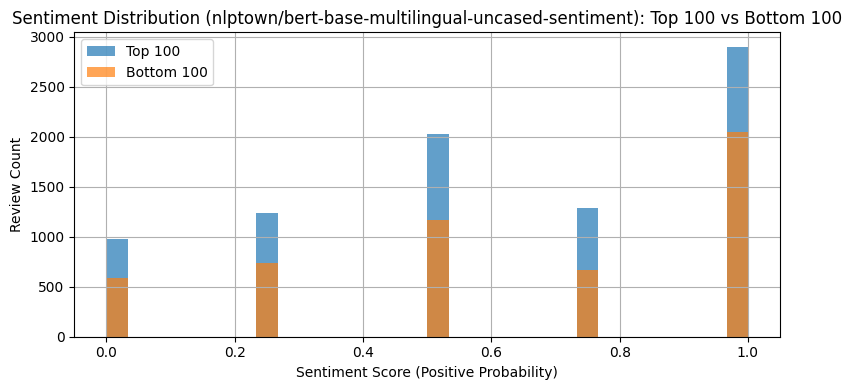

In [18]:
top_file = "C:/Users/User/Vscode/EDA25-1/data/naver_map_reviews_top100.csv"
bottom_file = "C:/Users/User/Vscode/EDA25-1/data/naver_map_reviews_bottom100.csv"

for m in model_info:
    analyze_sentiment_distribution(
        top_file=top_file,
        bottom_file=bottom_file,
        model_name=m["model_name"],
        save_prefix=m["save_prefix"],
        model_type=m["model_type"],
        positive_label=m["positive_label"],
    )